In [1]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# %%javascript
# // Evitar autoscroll.
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)

In [4]:
def testClassifier(clf,train,y_train,test,y_test):
    print("=== ",clf.__class__.__name__,end='')
    print(":",vars(clf))
    clf=clf.fit(train,y_train)
    #Predecimos las etiqueta del conjunto de prueba
    yp=clf.predict(test)
    # Medidas de bondad
    scores={}

    scores['Accuracy']=accuracy_score(y_test,yp)
    scores['Macro F1']=f1_score(y_test,yp,average='macro')
    scores['Macro Recall']=recall_score(y_test,yp,average='macro')
    scores['F1 is_humor=1']=f1_score(y_test,yp)
    
    print("Accuracy","Macro F1","Macro Recall","F1 is_humor=1",sep='\t')
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(
        scores['Accuracy'],scores['Macro F1'],scores['Macro Recall'],scores['F1 is_humor=1']))
                            
#     print("Recall: ", scores['recall'])
#     print("F1: ", scores['f1'])
#     print("Accuracy: ", scores['accuracy'])
#     print("F1 Humor: ", scores['f1_humor'])
    #Vemos la frontera de decisión
    plotDecisionBoundary(clf,train, y_train)
    return scores

## Un problema de texto  (Identificación de humor HAHA -2019)

Para este ejemplo utilizaremos los datos proporcionados para la tarea 1 del HAHA - Humor Analysis based on Human Annotation, la cual consiste determinar si tweets en español son humorísticos o no (un problema de clasificación binaria). Esta tarea forma parte del Iberian Languages Evaluation Forum (IberLEF 2019).

### Corpus 

El conjunto de datos fue etiquetado como se indica [5]. Todos los tweets están etiquetados como humorístico **is_humor=1**  o no humorístico **is_humor=0**. Los datos relevantes para el problema se clasificación ser muestran en el siguiente ejemplo:

|Desscripción|Clave|Valor|
|:------:|:------:|:-----:|
|Tweet |text|Después de la tormenta sale... Tu mamá gritando porque no metiste la ropa.|
|Etiqueta de clase|is_humor|1|
|Representación vectorial|vec| Vectores de dimensión 300 (FastText preentrenados para español) |
|Identificador|id|942079817905770496|



In [59]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre_min10.json',lines=True)

In [60]:
#Vemos los primeros 5
train_data.head()[['id','text','is_humor','vec']]

,id,text,is_humor,vec
0,965767017268678658,Amo a @CamilaTuDiosaxD,0,"[-0.06692000000000001, 0.13184, -0.0030723, -0..."
1,965811724392726528,@NamiNapoleon hola como estan me pueden seguir,0,"[-0.06776, -0.24253000000000002, -0.0065559999..."
2,964984559547777024,Típico : Estar viajando en taxi y pensar tácti...,1,"[-0.044634, -0.049435, -0.053049, -0.026851, 0..."
3,941669646364762113,Me gusta todo de ti.. te amo espejo.,1,"[-0.022054999999999998, -0.064284, -0.052083, ..."
4,1009142890415652866,""" Egipto siempre acaba afuera ""\r\n\r\nCleopatra",1,"[0.066164, -0.082201, -0.022706, -0.047533, 0...."


In [61]:
#Dimensión de los vectores
len(train_data.vec[3])

300

In [62]:
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre_min10.json',lines=True)

In [85]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fda290bbc90>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.708333	0.706920	0.710811	0.727273


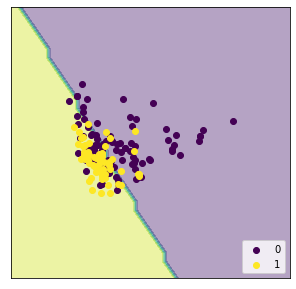

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fda29147210>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.708333	0.705550	0.711583	0.734177


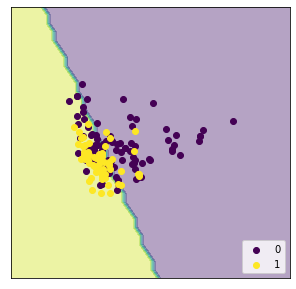

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fda290b8810>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.708333	0.706920	0.710811	0.727273


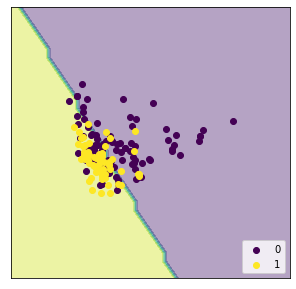

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fda290b8a90>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.486111	0.327103	0.500000	0.654206


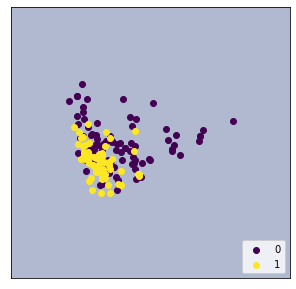

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fda292c74d0>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.722222	0.721362	0.724324	0.736842


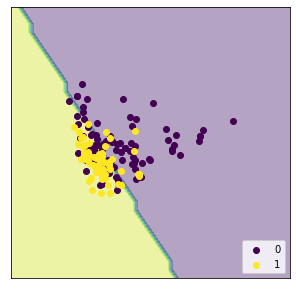

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fda31222c10>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.513889	0.339450	0.500000	0.000000


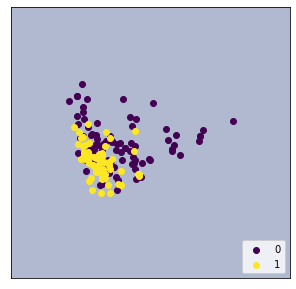

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fda290f7c90>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.708333	0.706920	0.710811	0.727273


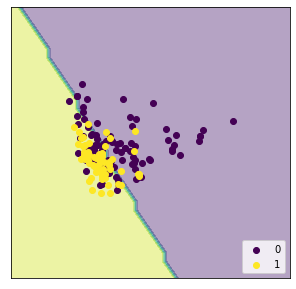

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fda30f39a90>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.708333	0.706920	0.710811	0.727273


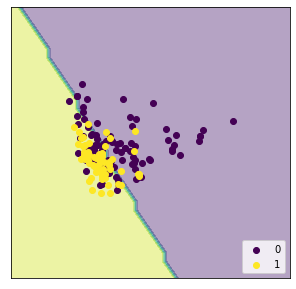

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fda28bee190>>, 'distance': 'coseno', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.680556	0.675485	0.677606	0.634921


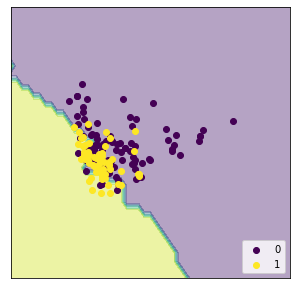

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fda3100b9d0>>, 'distance': 'euclidiana', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.638889	0.638610	0.638610	0.628571


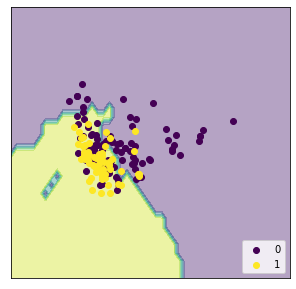

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fda289e64d0>>, 'distance': 'coseno', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.611111	0.610811	0.612355	0.621622
Implementación mean_dist


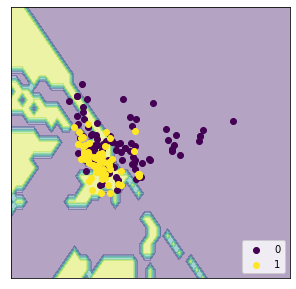

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fda31100b90>>, 'distance': 'euclidiana', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.680556	0.680000	0.679923	0.666667
Implementación mean_dist


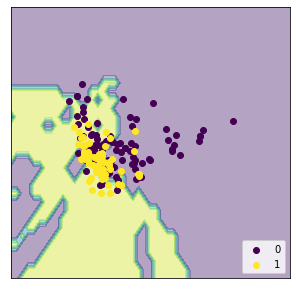

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fda30e66690>>, 'distance': 'coseno', 'k': 5}
Implementación weighed_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.680556	0.675485	0.677606	0.634921
Implementación weighed_dist


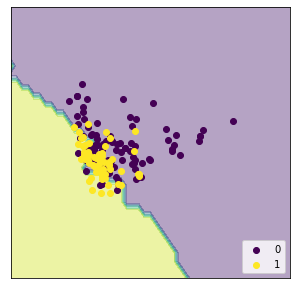

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fda28a04650>>, 'distance': 'euclidiana', 'k': 5}
Implementación weighed_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.638889	0.638610	0.638610	0.628571
Implementación weighed_dist


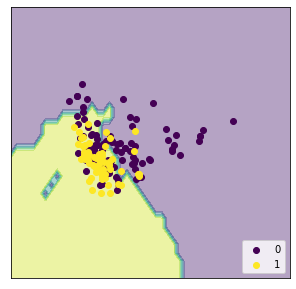

In [86]:
P={"FastText":{"Accuracy":0.809050,"Macro F1":0.793270,"Macro Recall":0.786900,"F1 is_humor=1":0.736140}} #Performance

# 
P["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train,y_train,test,y_test)
P["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train,y_train,test,y_test)

P["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train,y_train,test,y_test)
P["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train,y_train,test,y_test)

P["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)
P["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)

P["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train,y_train,test,y_test)
P["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train,y_train,test,y_test)


P["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train,y_train,test,y_test)
P["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train,y_train,test,y_test)

P["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train,y_train,test,y_test)
P["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train,y_train,test,y_test)

P["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)
P["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)

In [87]:
df=pd.DataFrame(P).T.sort_values("F1 is_humor=1",ascending =False)
df

,Accuracy,Macro F1,Macro Recall,F1 is_humor=1
NC.cos.rocchio,0.722222,0.721362,0.724324,0.736842
FastText,0.809050,0.793270,0.786900,0.736140
NC.euc.avg,0.708333,0.705550,0.711583,0.734177
NC.cos.avg,0.708333,0.706920,0.710811,0.727273
NC.cos.sum,0.708333,0.706920,0.710811,0.727273
NC.cos.nsum,0.708333,0.706920,0.710811,0.727273
NC.euc.nsum,0.708333,0.706920,0.710811,0.727273
KNN.euc.m,0.680556,0.680000,0.679923,0.666667
NC.euc.sum,0.486111,0.327103,0.500000,0.654206
KNN.cos.u,0.680556,0.675485,0.677606,0.634921


In [16]:
from toolbox import *

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
!wc -l data/haha_*.json
!cat data/haha_train_ft_pre_min10.json > data/haha_all_ft_pre_min10.json
!cat data/haha_test_ft_pre_min10.json >> data/haha_all_ft_pre_min10.json
!wc -l data/haha_all_ft_pre_min10.json

!rm -f *.pickle
inv_idx = InvertedIdx("data/haha_all_ft_pre_min10.json")
inv_idx.process(showProgressEach=10000, stemm=False)
inv_idx.compute_mtx()
tfidf=pd.DataFrame(inv_idx.idx_mtx.todense(), index=inv_idx.corpus).T
tfidf

     240 data/haha_all_ft_pre_min10.json
    7201 data/haha_test_ft_pre.json
      72 data/haha_test_ft_pre_min10.json
   16799 data/haha_train_ft_pre.json
     168 data/haha_train_ft_pre_min10.json
   24480 total
240 data/haha_all_ft_pre_min10.json
** Processing data/haha_all_ft_pre_min10.json ...
2020-05-09 03:17:18.354986 :: 0.000335 - Processing item #0 
** Processed 240 lines. Saved to /home/jovyan/B5_Clasificacion/tokenized_docs.pickle.
** Computing TF-IDF...
** Computed TF-IDF Matrix !!!
** Done poda0 TF-IDF Matrix !!!
poda0_mtx.pickle written.


<1230x240 sparse matrix of type '<class 'numpy.float64'>'
	with 1738 stored elements in List of Lists format>

,aah,abejas,abogados,abono,abraham,abrazamee,abrir,abuela,abuelas,aburrimiento,...,workshowsperu,xd,xra,xvideos,yahoo,yotrasmanerasdeenamorarme,you,yoyanose,zavees,zoe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
train2=np.ascontiguousarray(tfidf.head(168).to_numpy())
test2=np.ascontiguousarray(tfidf.tail(72).to_numpy())
train2.shape,test2.shape

((168, 1230), (72, 1230))

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fda3124e850>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.552448	0.553668	0.515152


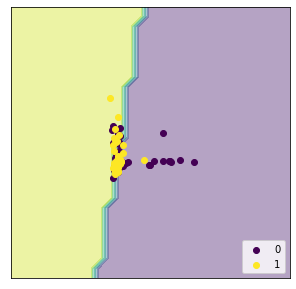

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fda291e9550>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.527778	0.456965	0.518147	0.260870


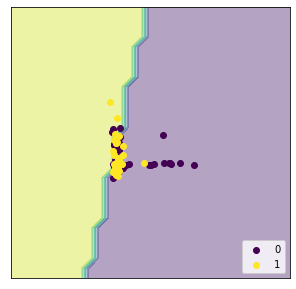

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fda292c4350>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.552448	0.553668	0.515152


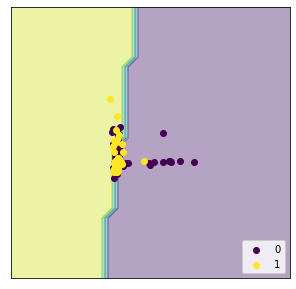

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fda290d7950>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.486111	0.327103	0.500000	0.654206


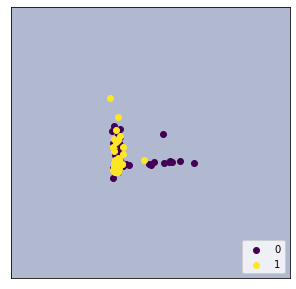

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fda29231810>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.550000	0.552896	0.500000


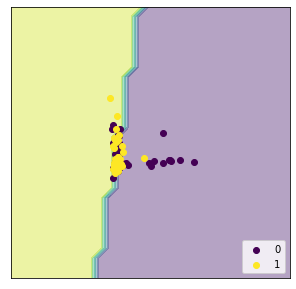

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fda29242b50>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.513889	0.339450	0.500000	0.000000


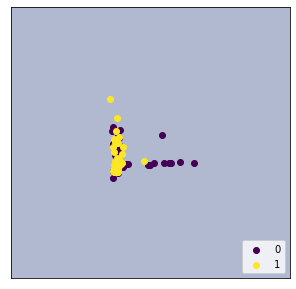

===  NearestCentroid: {'distance': <function coseno at 0x7fda074dab00>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fda2918d550>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.552448	0.553668	0.515152


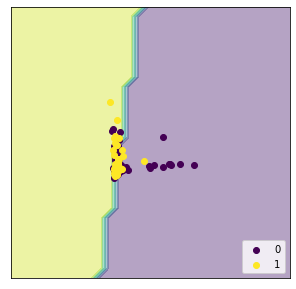

===  NearestCentroid: {'distance': <function euclidiana at 0x7fda0999f9e0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fda2918d810>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.486111	0.485217	0.487645	0.506667


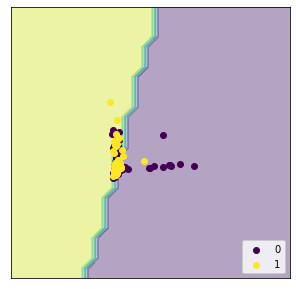

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fda29105190>>, 'distance': 'coseno', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.458333	0.458229	0.459073	0.465753


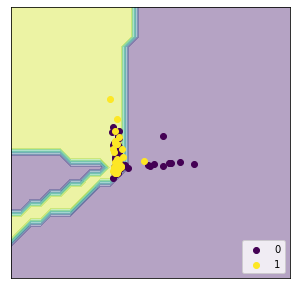

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fda29260fd0>>, 'distance': 'euclidiana', 'k': 5}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.597222	0.573442	0.591120	0.472727


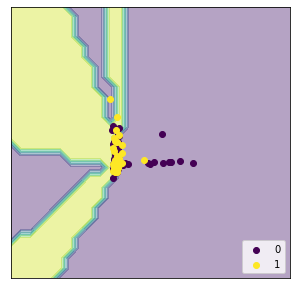

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fda077999d0>>, 'distance': 'coseno', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.552448	0.553668	0.515152
Implementación mean_dist


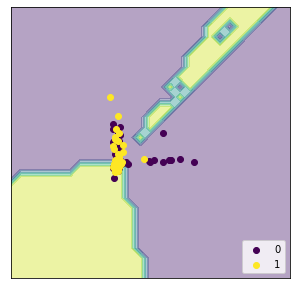

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fda3148d050>>, 'distance': 'euclidiana', 'k': 5}
Implementación mean_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.500000	0.485714	0.495753	0.400000
Implementación mean_dist


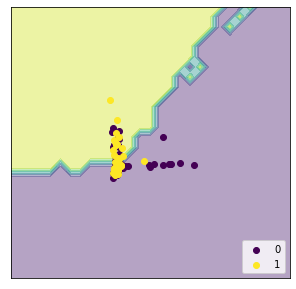

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fda30fbd6d0>>, 'distance': 'coseno', 'k': 5}
Implementación weighed_dist


/home/jovyan/B5_Clasificacion/skeleton.py:249: RuntimeWarning: divide by zero encountered in reciprocal
  dtype='float32')


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.555556	0.525926	0.549035	0.407407
Implementación weighed_dist


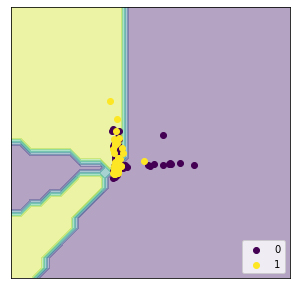

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fda30f4dd10>>, 'distance': 'euclidiana', 'k': 5}
Implementación weighed_dist
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.597222	0.573442	0.591120	0.472727
Implementación weighed_dist


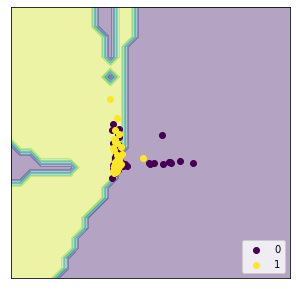

In [89]:
P2={} #Performance

# 
P2["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train2,y_train,test2,y_test)
P2["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train2,y_train,test2,y_test)

P2["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train2,y_train,test2,y_test)
P2["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train2,y_train,test2,y_test)

P2["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)
P2["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)

P2["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train2,y_train,test2,y_test)
P2["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train2,y_train,test2,y_test)


P2["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train2,y_train,test2,y_test)
P2["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train2,y_train,test2,y_test)

P2["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)

P2["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)

In [90]:
df2=pd.DataFrame(P2).T.sort_values("F1 is_humor=1",ascending =False)
df2

,Accuracy,Macro F1,Macro Recall,F1 is_humor=1
NC.euc.sum,0.486111,0.327103,0.500000,0.654206
NC.cos.avg,0.555556,0.552448,0.553668,0.515152
NC.cos.sum,0.555556,0.552448,0.553668,0.515152
NC.cos.nsum,0.555556,0.552448,0.553668,0.515152
KNN.cos.m,0.555556,0.552448,0.553668,0.515152
NC.euc.nsum,0.486111,0.485217,0.487645,0.506667
NC.cos.rocchio,0.555556,0.550000,0.552896,0.500000
KNN.euc.u,0.597222,0.573442,0.591120,0.472727
KNN.euc.w,0.597222,0.573442,0.591120,0.472727
KNN.cos.u,0.458333,0.458229,0.459073,0.465753


In [91]:
df.describe()

,Accuracy,Macro F1,Macro Recall,F1 is_humor=1
count,15.000000,15.000000,15.000000,15.000000
mean,0.666900,0.642228,0.666051,0.639049
std,0.081586,0.132411,0.079319,0.183051
min,0.486111,0.327103,0.500000,0.000000
25%,0.638889,0.638610,0.638610,0.631746
50%,0.680556,0.680000,0.679923,0.666667
75%,0.708333,0.706920,0.710811,0.727273
max,0.809050,0.793270,0.786900,0.736842


In [92]:
df2.describe()

,Accuracy,Macro F1,Macro Recall,F1 is_humor=1
count,14.000000,14.000000,14.000000,14.000000
mean,0.535714,0.498948,0.532819,0.442926
std,0.041743,0.080688,0.039638,0.153812
min,0.458333,0.327103,0.459073,0.000000
25%,0.503472,0.464976,0.500000,0.421994
50%,0.555556,0.537963,0.550965,0.486364
75%,0.555556,0.552448,0.553668,0.515152
max,0.597222,0.573442,0.591120,0.654206
